<big>**Problem setup**</big>

We will solve an inverse problem for the diffusion equation with an unknown parameter $C$
$$\frac{\partial y}{\partial t}=C\frac{\partial^2y}{\partial x^2}-e^{-t}(\sin(\pi x)-\pi^2\sin(\pi x)),\quad x\in[-1,1],\quad t\in[0,1]$$

with the initial condition:
$$y(x,0)=\sin(\pi x)$$

and the Dirichlet boundary condition:
$$y(-1,t)=y(1,t)=0.$$

The reference solution is:
$$y=e^{-t}\sin(\pi x).$$

<big>**Implementation**</big>

This description goes through the implementation of a solver for the above described diffusion equation step-by-step

In [31]:
import deepxde as dde
import numpy as np
import torch

We begin by defining computational geometries. We can use a built-in class Interval and TimeDomain and we combine both the domains using GeometryXTime as follows:

In [32]:
geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

Next, we express the PDE residual of the diffusion equation:

In [33]:
def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    # Backend pytorch
    return (
        dy_t
        - C * dy_xx
        + torch.exp(-x[:, 1:])
        * (torch.sin(np.pi * x[:, 0:1]) - np.pi ** 2 * torch.sin(np.pi * x[:, 0:1]))
    )

def func(x):
    return np.sin(np.pi * x[:, 0:1]) * np.exp(-x[:, 1:])

The first argument to pde is the 2 dimensional vector where the first component x[:, 0] is the $x$-coordinate; and the second component x[:, 1] is the $t$-coordinate. The second argument is the network output, i.e., the solution $u(x,t)$, but here we use $y$ as the name of the variable. 

Here C is an unknown parameter with initial value 2.0:

In [34]:
C = dde.Variable(2.0)

Next, we consider the boundary/initial condition. on_boundary is chosen here to use the whole boundary of the computational domain in considered as the boundary condition. We include the geotime space , time geometry created above and on_boundary as the BC in the DirichletBC function of DeepXDE. We also define IC which is the initial condition for the diffusion equation and we use the computational domain, initial function, and on_initial to specify the IC.

In [35]:
bc = dde.icbc.DirichletBC(geomtime, func, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(geomtime, func, lambda _, on_initial: on_initial)

The reference solution func is defined as:

In [36]:
def func(x):
    return np.sin(np.pi * x[:, 0:1]) * np.exp(-x[:, 1:])

In this problem, we provide extra information on some training points and the parameter $C$ can be identified from these observations. We generate a 2-dimensional array observe_x of 10 equally-spaced input points $(x,t)$ as the first argument to PointSetBC, where $x$ is in $[-1,1]$ and $t = 1$. The second argument func(observe_x) is the corresponding exact solution. PointSetBC compares observe_x and func(observe_x), and they satisfy the Dirichlet boundary condition.

In [37]:
observe_x = np.vstack((np.linspace(-1, 1, num=10), np.full((10), 1))).T
observe_y = dde.icbc.PointSetBC(observe_x, func(observe_x), component=0)

Now, we have specified the geometry, PDE residual, boundary/initial condition, and extra observations. We then define the TimePDE problem as

In [38]:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic, observe_y],
    num_domain=40,
    num_boundary=20,
    num_initial=10,
    anchors=observe_x,
    solution=func,
    num_test=10000,
)

The number 40 is the number of training residual points sampled inside the domain, and the number 20 is the number of training points sampled on the boundary (the left and right endpoints of the interval). We also include 10 initial residual points for the initial conditions and 10000 points for testing the PDE residual. The argument anchors is the above described training points in addition to the num_domain, num_initial, and num_boundary sampled points.

数字 40 是在域内采样的训练残差点数，数字 20 是在边界（区间的左右端点）采样的训练点数。我们还包括 10 个用于初始条件的初始残差点和 10000 个用于测试 PDE 残差的点。参数 anchors 是除 num_domain、num_initial 和 num_boundary 采样点之外的上述训练点。

Next, we choose the network. Here, we use a fully connected neural network of depth 4 (i.e., 3 hidden layers) and width 32:

In [39]:
layer_size = [2] + [32] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

Now, we have the PDE problem and the network. We build a Model and choose the optimizer and learning rate, and the unknown parameter C is passed as external_trainable_variables:

In [40]:
model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"], external_trainable_variables=C)

Compiling model...
'compile' took 0.000748 s



We then train the model for 50000 iterations. During the training process, we output the value of $C$ every 1000 iterations:

In [41]:
variable = dde.callbacks.VariableValue([C], period=1000,filename="variables.dat")
losshistory, train_state = model.train(iterations=50000, callbacks=[variable])

Training model...

Step      Train loss                                  Test loss                                   Test metric   
0         [1.33e+01, 2.98e-02, 4.82e-01, 1.44e-01]    [1.55e+01, 2.98e-02, 4.82e-01, 1.44e-01]    [1.03e+00]    
0 [2.00e+00]
1000      [6.15e-03, 1.95e-02, 4.50e-02, 1.62e-02]    [8.22e-03, 1.95e-02, 4.50e-02, 1.62e-02]    [4.04e-01]    
1000 [1.98e+00]
2000      [1.71e-03, 4.61e-03, 1.15e-02, 7.72e-03]    [2.15e-03, 4.61e-03, 1.15e-02, 7.72e-03]    [3.98e-01]    
2000 [1.70e+00]
3000      [7.91e-04, 9.59e-04, 1.15e-03, 3.95e-03]    [5.93e-03, 9.59e-04, 1.15e-03, 3.95e-03]    [2.74e-01]    
3000 [1.41e+00]
4000      [2.07e-04, 3.55e-04, 1.31e-05, 1.29e-03]    [3.14e-03, 3.55e-04, 1.31e-05, 1.29e-03]    [1.51e-01]    
4000 [1.20e+00]
5000      [2.01e-04, 8.82e-05, 1.86e-05, 2.37e-04]    [9.99e-04, 8.82e-05, 1.86e-05, 2.37e-04]    [6.31e-02]    
5000 [1.08e+00]
6000      [1.31e-04, 2.55e-05, 1.11e-05, 5.04e-05]    [5.11e-04, 2.55e-05, 1.11e-05, 5.04e-05]   

We also save and plot the best trained result and loss history.

Saving loss history to h:\毕业论文\demo\demo_RD_inverse_1D\loss.dat ...
Saving training data to h:\毕业论文\demo\demo_RD_inverse_1D\train.dat ...
Saving test data to h:\毕业论文\demo\demo_RD_inverse_1D\test.dat ...


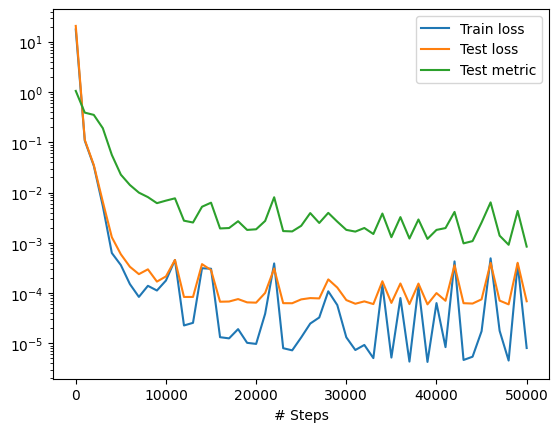

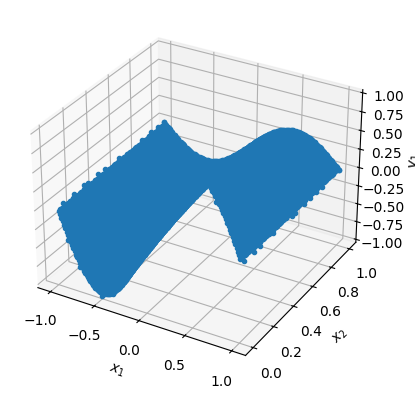

In [ ]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)
variable = dde.callbacks.VariableValue([C], period=1000, filename="variables.dat")